No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Sentiment Analysis Complete. Columns now include:  Index(['text', 'Created_At', 'label', 'cleaned_text', 'augmented_text',
       'sentiment'],
      dtype='object')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Fold 1/2
Epoch 1/2, Loss: 0.451574892463053
Epoch 2/2, Loss: 0.21179195822161787
Fold 1 Accuracy: 0.9266821345707656
Training Fold 2/2
Epoch 1/2, Loss: 0.18987514484016335
Epoch 2/2, Loss: 0.09774731561158072
Fold 2 Accuracy: 0.9651972157772621
Final Cross-Validated Accuracy: 0.9459396751740139
Precision: 0.9305555555555556, Recall: 0.9638051044083527, F1-Score: 0.9468885343059038


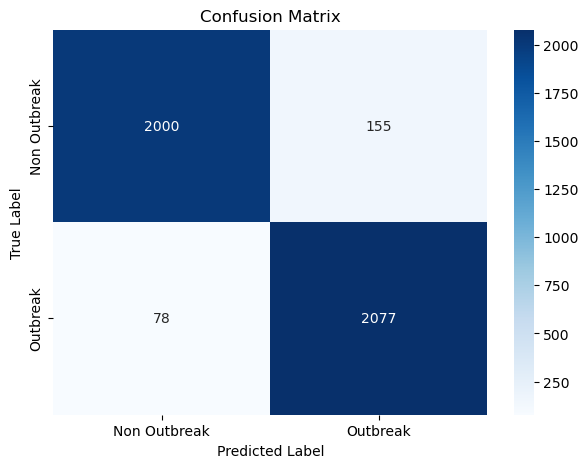

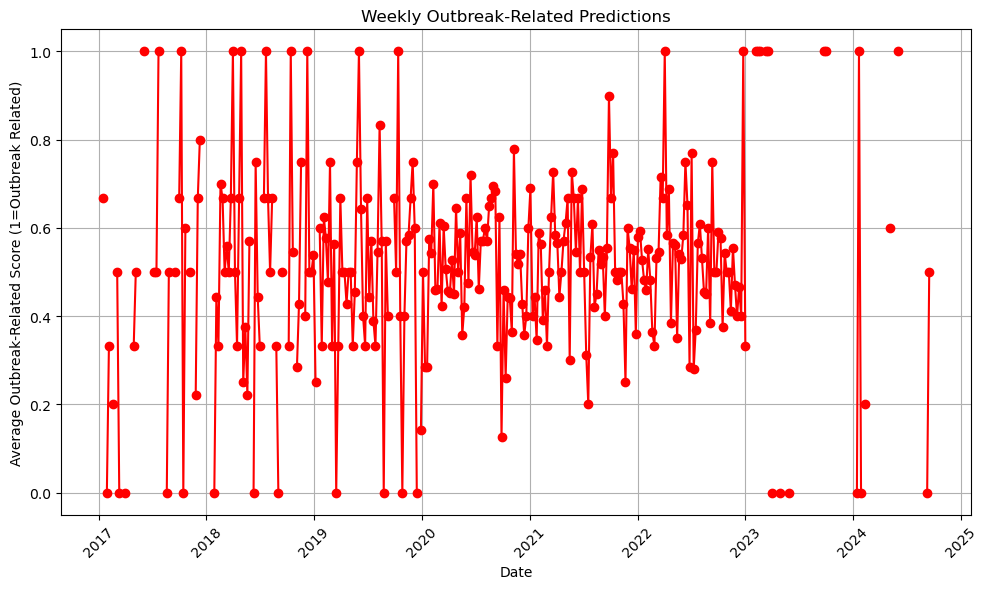

TypeError: 'Tensor' object is not callable

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
import re
import nlpaug.augmenter.word as naw
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import shap  # For explainability

# Configurable Hyperparameters
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
EPOCHS = 2
SMOTE_ENABLED = True  # Set to True to use SMOTE, False to use SynonymAug
AUGMENTATION_METHOD = 'synonym'  # Options: 'synonym' or 'smote'

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Step 1: Load the datasets
news_data = pd.read_csv('/Users/m1/Downloads/data/VHF/EWS/news_article.csv')
tweets_data = pd.read_csv('/Users/m1/Downloads/data/VHF/EWS/tweets.csv')

# Step 2: Drop irrelevant columns
columns_to_drop = ['id', 'Tweet_count', 'Retweet_Count', 'User', 'Favorite_Count', 'Comments', 'link', 'publisher']
tweets_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
news_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Step 3: Handle Datetime columns in both datasets
tweets_data['Created_At'] = pd.to_datetime(tweets_data['Created_At'], errors='coerce', format='%a %b %d %H:%M:%S %z %Y').dt.tz_localize(None)
news_data['date published'] = pd.to_datetime(news_data['date published'], errors='coerce', format='%d/%m/%Y %H:%M')
news_data.rename(columns={'date published': 'Created_At'}, inplace=True)

# Step 4: Data Cleaning and Preprocessing
def clean_text(text):
    """Cleans text data by removing URLs and special characters."""
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning
tweets_data['cleaned_text'] = tweets_data['text'].apply(clean_text)
news_data['cleaned_text'] = news_data['text'].apply(clean_text)

# Combine datasets
merged_data = pd.concat([tweets_data, news_data], ignore_index=True)

# Step 5: Data Augmentation (Handling Imbalance)
if AUGMENTATION_METHOD == 'synonym':
    # Using synonym replacement for augmentation
    aug = naw.SynonymAug(aug_src='wordnet')
    majority_class = merged_data[merged_data['label'] == 'Outbreak Related']
    minority_class = merged_data[merged_data['label'] == 'Non Outbreak Related']

    # Upsample minority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
    minority_upsampled['augmented_text'] = minority_upsampled['cleaned_text'].apply(lambda x: ' '.join(aug.augment(x)))
    merged_data_balanced = pd.concat([majority_class, minority_upsampled]).sample(frac=1, random_state=42)

elif AUGMENTATION_METHOD == 'smote' and SMOTE_ENABLED:
    # Using SMOTE for oversampling
    X = merged_data['cleaned_text']
    y = merged_data['label']

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train.values.reshape(-1, 1), y_train)
    merged_data_balanced = pd.DataFrame(X_resampled, columns=['cleaned_text'])
    merged_data_balanced['label'] = y_resampled

# Step 6: Convert 'label' column to numeric
merged_data_balanced['label'] = merged_data_balanced['label'].map({
    'Non Outbreak Related': 0,
    'Outbreak Related': 1
})

# Step 7: Initialize Sentiment Analysis
sentiment_analyzer = pipeline("sentiment-analysis")

# Step 8: Sentiment Analysis on cleaned text
merged_data_balanced['sentiment'] = merged_data_balanced['cleaned_text'].apply(lambda x: sentiment_analyzer(x)[0]['label'])
print("Sentiment Analysis Complete. Columns now include: ", merged_data_balanced.columns)

# Convert sentiment to numeric
merged_data_balanced['sentiment_numeric'] = merged_data_balanced['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Step 9: Tokenization using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text_list):
    """Tokenizes text data using BERT tokenizer."""
    return tokenizer(text_list, padding=True, truncation=True, max_length=64, return_tensors='pt')

# Tokenize the text
merged_data_balanced['combined_text'] = merged_data_balanced['cleaned_text'].astype(str)
tokenized_data = tokenize_text(merged_data_balanced['combined_text'].tolist())
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Encode labels
labels = torch.tensor(merged_data_balanced['label'].values)

# Step 10: BERT Model Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Cross-validation with StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Mixed Precision Training using GradScaler
scaler = GradScaler(enabled=torch.cuda.is_available())

# Training Loop
accuracy_scores = []
all_predictions = []
all_true_labels = []

for fold, (train_idx, test_idx) in enumerate(skf.split(input_ids, labels)):
    print(f"Training Fold {fold + 1}/{skf.get_n_splits()}")

    train_inputs, test_inputs = input_ids[train_idx], input_ids[test_idx]
    train_masks, test_masks = attention_masks[train_idx], attention_masks[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    # Create DataLoaders
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=BATCH_SIZE)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=BATCH_SIZE)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    # Train the model
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_attention_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()

            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_dataloader)}")

    # Evaluate the model
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_attention_mask = batch[0].to(device), batch[1].to(device)
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).flatten()

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch[2].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    accuracy_scores.append(accuracy)
    all_predictions.extend(predictions)
    all_true_labels.extend(true_labels)

    print(f"Fold {fold + 1} Accuracy: {accuracy}")

# Final Evaluation Metrics
final_accuracy = accuracy_score(all_true_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='binary')
print(f"Final Cross-Validated Accuracy: {final_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Outbreak', 'Outbreak'], yticklabels=['Non Outbreak', 'Outbreak'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save predictions and true labels to CSV for ensemble learning
predictions_df = pd.DataFrame({
    'True_Label': all_true_labels,
    'Predicted_Label': all_predictions
})
predictions_df.to_csv('ensemble_model_predictions.csv', index=False)
print("Predictions saved to 'ensemble_model_predictions.csv'.")

# Step 11: Temporal Outbreak Predictions (Integrated)
merged_data_balanced['outbreak_prediction'] = all_predictions

# Resample outbreak predictions weekly
weekly_outbreak_predictions = merged_data_balanced.set_index('Created_At').resample('W').outbreak_prediction.mean()

# Plot the outbreak-related predictions over time
plt.figure(figsize=(10, 6))
plt.plot(weekly_outbreak_predictions, marker='o', linestyle='-', color='r')
plt.title('Weekly Outbreak-Related Predictions')
plt.ylabel('Average Outbreak-Related Score (1=Outbreak Related)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
import re
import nlpaug.augmenter.word as naw
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Configurable Hyperparameters
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
EPOCHS = 2
SMOTE_ENABLED = True  # Set to True to use SMOTE, False to use SynonymAug
AUGMENTATION_METHOD = 'synonym'  # Options: 'synonym' or 'smote'

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Step 1: Load the datasets
news_data = pd.read_csv('/Users/m1/Downloads/data/VHF/EWS/news_article.csv')
tweets_data = pd.read_csv('/Users/m1/Downloads/data/VHF/EWS/tweets.csv')

# Step 2: Drop irrelevant columns
columns_to_drop = ['id', 'Tweet_count', 'Retweet_Count', 'User', 'Favorite_Count', 'Comments', 'link', 'publisher']
tweets_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
news_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Step 3: Handle Datetime columns in both datasets
tweets_data['Created_At'] = pd.to_datetime(tweets_data['Created_At'], errors='coerce', format='%a %b %d %H:%M:%S %z %Y').dt.tz_localize(None)
news_data['date published'] = pd.to_datetime(news_data['date published'], errors='coerce', format='%d/%m/%Y %H:%M')
news_data.rename(columns={'date published': 'Created_At'}, inplace=True)

# Step 4: Data Cleaning and Preprocessing
def clean_text(text):
    """Cleans text data by removing URLs and special characters."""
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning
tweets_data['cleaned_text'] = tweets_data['text'].apply(clean_text)
news_data['cleaned_text'] = news_data['text'].apply(clean_text)

# Combine datasets
merged_data = pd.concat([tweets_data, news_data], ignore_index=True)

# Step 5: Data Augmentation (Handling Imbalance)
if AUGMENTATION_METHOD == 'synonym':
    # Using synonym replacement for augmentation
    aug = naw.SynonymAug(aug_src='wordnet')
    majority_class = merged_data[merged_data['label'] == 'Outbreak Related']
    minority_class = merged_data[merged_data['label'] == 'Non Outbreak Related']

    # Upsample minority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
    minority_upsampled['augmented_text'] = minority_upsampled['cleaned_text'].apply(lambda x: ' '.join(aug.augment(x)))
    merged_data_balanced = pd.concat([majority_class, minority_upsampled]).sample(frac=1, random_state=42)

elif AUGMENTATION_METHOD == 'smote' and SMOTE_ENABLED:
    # Using SMOTE for oversampling
    from sklearn.model_selection import train_test_split
    X = merged_data['cleaned_text']
    y = merged_data['label']

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train.values.reshape(-1, 1), y_train)
    merged_data_balanced = pd.DataFrame(X_resampled, columns=['cleaned_text'])
    merged_data_balanced['label'] = y_resampled

# Step 6: Convert 'label' column to numeric
merged_data_balanced['label'] = merged_data_balanced['label'].map({
    'Non Outbreak Related': 0,
    'Outbreak Related': 1
})

# Step 7: Initialize Sentiment Analysis
sentiment_analyzer = pipeline("sentiment-analysis")

# Step 8: Sentiment Analysis on cleaned text
merged_data_balanced['sentiment'] = merged_data_balanced['cleaned_text'].apply(lambda x: sentiment_analyzer(x)[0]['label'])
print("Sentiment Analysis Complete. Columns now include: ", merged_data_balanced.columns)

# Convert sentiment to numeric
merged_data_balanced['sentiment_numeric'] = merged_data_balanced['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Step 9: Tokenization using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text_list):
    """Tokenizes text data using BERT tokenizer."""
    return tokenizer(text_list, padding=True, truncation=True, max_length=64, return_tensors='pt')

# Tokenize the text
merged_data_balanced['combined_text'] = merged_data_balanced['cleaned_text'].astype(str)
tokenized_data = tokenize_text(merged_data_balanced['combined_text'].tolist())
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Encode labels
labels = torch.tensor(merged_data_balanced['label'].values)

# Step 10: BERT Model Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Cross-validation with StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Mixed Precision Training using GradScaler
scaler = GradScaler(enabled=torch.cuda.is_available())

# Training Loop
accuracy_scores = []
all_predictions = []
all_true_labels = []

for fold, (train_idx, test_idx) in enumerate(skf.split(input_ids, labels)):
    print(f"Training Fold {fold + 1}/{skf.get_n_splits()}")

    train_inputs, test_inputs = input_ids[train_idx], input_ids[test_idx]
    train_masks, test_masks = attention_masks[train_idx], attention_masks[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    # Create DataLoaders
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=BATCH_SIZE)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=BATCH_SIZE)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    # Train the model
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_attention_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()

            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_dataloader)}")

    # Evaluate the model
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_attention_mask = batch[0].to(device), batch[1].to(device)
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).flatten()

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch[2].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    accuracy_scores.append(accuracy)
    all_predictions.extend(predictions)
    all_true_labels.extend(true_labels)

    print(f"Fold {fold + 1} Accuracy: {accuracy}")

# Final Evaluation Metrics
final_accuracy = accuracy_score(all_true_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='binary')
print(f"Final Cross-Validated Accuracy: {final_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Outbreak', 'Outbreak'], yticklabels=['Non Outbreak', 'Outbreak'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 11: Temporal Outbreak Predictions (Integrated)
merged_data_balanced['outbreak_prediction'] = all_predictions

# Resample outbreak predictions weekly
weekly_outbreak_predictions = merged_data_balanced.set_index('Created_At').resample('W').outbreak_prediction.mean()

# Plot the outbreak-related predictions over time
plt.figure(figsize=(10, 6))
plt.plot(weekly_outbreak_predictions, marker='o', linestyle='-', color='r')
plt.title('Weekly Outbreak-Related Predictions')
plt.ylabel('Average Outbreak-Related Score (1=Outbreak Related)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
